HW 4 (584): Recommender Systems
Published Date:
18 Oct 2021, 4:57 p.m.
Deadline Date:
2 Nov 2021, 11:59 p.m.
Description:
*******************************************************************

This is a team assignment with maximum size of 2. Individual assignments submissions are also permitted

********************************************************************

Overview and Assignment Goals:

The objectives of this assignment are the following:
Develop a Recommender System that Uses the Rating Information (Matrix) and Side-Information (i.e., Additional Content).
Think about using classification, clustering, or anything you learned this semester.
The Scoring Metric will be Root Mean Squared Error (RMSE) where the predictions are rating in the range 0-5. As such, you may want to switch to a regression setting since the output can be real-valued.

Detailed Description:

Recommender Systems are all pervasive. The objective of this movie recommender system is to predict the 5-star rating a movie will get for a given user. You can use content features as well as the rating matrix to make your final predictions.
Data Description:

As part of the training I provide you several different files all zipped together as additional_files.zip (Uploaded in the training portion of this assignment).

Once you unzip this file you will find a readme.txt with a listing of the files and useful information about them (replicated below).

* train.dat: This file contains the rating of a user for a given movie.

* test.dat: This file contains user movie pairs but no rating (Your goal is to predict these ratings for user-movie pairs)

* movie_genres.dat: This file contains the genres of the movies.

* movie_directors.dat: This file contains the directors of the movies. .

* movie_actors.dat: This file contains the main actors and actresses of the movies. A ranking is given to the actors of each movie according to the order in which they appear on the movie IMDb cast web page. .

* tags.dat: This file contains the set of tags available in the dataset. .

* user_taggedmovies.dat: These files contain the tag assignments of the movies provided by each particular user. .

* movie_tags.dat: This file contains the tags assigned to the movies, and the number of times the tags were assigned to each movie. .

test.dat: Test set consisting of user-movie pairs for which you need to produce the ratings

example_entry.dat: A sample submission with 71299 entries in the range of 0-5.

Rules:
Discussion of broad level strategies are allowed but any copying of submission files and source codes will result in honor code violation. Similarly, it's never acceptable to copy code from the internet, even if you cite the source. Doing so will result in honor code violation.
Feel free to use the programming language of your choice for this assignment.
While you can use (most) libraries and templates for dealing with this problem, you are not allowed to use the modules that do everything (or most of the work) for you (e.g. the surprise package in python, LightFM, MediaLite are not allowed). If you choose to use any existing libraries, you should be able to explain these methods and their choice in sufficient detail.
You are allowed 10 submissions in a 24 hour cycle.
Deliverables:
Valid Submissions to the Miner Website
Gradescope Submission of Source Code and Report:
Create a folder called HW4_LastName_(Lname2).
Create a subfolder called src and put all the source code there.
Create a subfolder called Report and place a 3-4 page, single-spaced report describing details regarding the steps you followed for developing the recommender system. Be sure to include the following in the report:
Username Registered on miner website.
Ranks & RMSE score for your submission (at the time of writing the report).
Your Approach
Your methodology of choosing the approach, the content features you used if any and what worked, what did not?
Archive your parent folder (.zip or .tar.gz) and submit via Gradescope for HW4.
Grading:
Grading for the Assignment will be split on your implementation (40%), report (30%) and ranking results (30%).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.sparse import csr_matrix

In [5]:
# Read the file and store the data
def readTrainfile(filepath, sep):
    read_data = pd.read_csv(filepath, sep=sep)
    return read_data

# Save the file the output file
def saveOutput(filePath, data):
    # writing to .txt
    np.savetxt(filePath, data, fmt='%s')

# Save the data to csv
def saveCSV(data,namefile):
    data.to_csv(namefile, encoding='utf-8', index=False)

In [8]:
test =readTrainfile(filepath="./additional_files/test.dat", sep= ' ')
movie_actors = readTrainfile(filepath="././additional_files/movie_actors.dat", sep= '\t')
movie_directors= readTrainfile(filepath="./additional_files/movie_directors.dat", sep= '\t')
movie_genres= readTrainfile(filepath="./additional_files/movie_genres.dat", sep= '\t')
movie_tags= readTrainfile(filepath="./additional_files/movie_tags.dat", sep= '\t')
tags= readTrainfile(filepath="./additional_files/tags.dat", sep= '\t')
train= readTrainfile(filepath="./additional_files/train.dat", sep= ' ')
user_taggedmovies= readTrainfile(filepath="./additional_files/user_taggedmovies.dat", sep= ' ')

In [7]:
train['rating']=train['rating']*2
train

,userID,movieID,rating
0,75,3,2.0
1,75,32,9.0
2,75,110,8.0
3,75,163,8.0
4,75,165,9.0
...,...,...,...
641694,71534,42900,8.0
641695,71534,44555,8.0
641696,71534,46578,8.0
641697,71534,61075,10.0


In [9]:
tags=tags.rename(columns={'id':'tagID'})
tags

,tagID,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale
...,...,...
13217,16524,good in its day
13218,16525,isaiah
13219,16527,top 5 movie
13220,16528,vontatott


In [10]:
# merge usertag and main train data (userid, movieid)
train_data = train.merge(user_taggedmovies, on=['userID','movieID'], how ='left')
train_data = train_data.merge(movie_tags, on=['movieID','tagID'], how = 'left')
train_data = train_data.merge(movie_genres, on='movieID', how = 'left')
train_data = train_data.merge(movie_directors, on='movieID', how = 'left')
train_data = train_data.merge(movie_actors, on='movieID', how='left')
train_data = train_data.merge(tags, on='tagID', how='left')

#47651632 X 11
#47651632 rows × 12 columns
train_data

,userID,movieID,rating,tagID,tagWeight,genre,directorID,directorName,actorID,actorName,ranking,value
0,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,annmargret,Ann-Margret,3.0,NaN
1,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,buck_henry,Buck Henry,8.0,NaN
2,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,buffy_sedlachek,Buffy Sedlachek,13.0,NaN
3,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,burgess_meredith,Burgess Meredith,4.0,NaN
4,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,christopher_mcdonald,Christopher McDonald,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
47651627,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,roger_lloyd_pack,Roger Lloyd Pack,17.0,NaN
47651628,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,rolf_saxon,Rolf Saxon,25.0,NaN
47651629,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,rupert_baderman,Rupert Baderman,8.0,NaN
47651630,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,shirley_stelfox,Shirley Stelfox,19.0,NaN


In [44]:
train_data['tagID']=train_data['tagID'].fillna(0)
train_data['tagWeight']=train_data['tagWeight'].fillna(0)
train_data['value']=train_data['value'].fillna("")
train_data

,userID,movieID,rating,tagID,tagWeight,genre,directorID,directorName,actorID,actorName,ranking,value
0,75,3,1.0,0.0,0.0,Comedy,donald_petrie,Donald Petrie,annmargret,Ann-Margret,3.0,
1,75,3,1.0,0.0,0.0,Comedy,donald_petrie,Donald Petrie,buck_henry,Buck Henry,8.0,
2,75,3,1.0,0.0,0.0,Comedy,donald_petrie,Donald Petrie,buffy_sedlachek,Buffy Sedlachek,13.0,
3,75,3,1.0,0.0,0.0,Comedy,donald_petrie,Donald Petrie,burgess_meredith,Burgess Meredith,4.0,
4,75,3,1.0,0.0,0.0,Comedy,donald_petrie,Donald Petrie,christopher_mcdonald,Christopher McDonald,9.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
47651627,71534,62049,4.5,0.0,0.0,Sci-Fi,michael_radford,Michael Radford,roger_lloyd_pack,Roger Lloyd Pack,17.0,
47651628,71534,62049,4.5,0.0,0.0,Sci-Fi,michael_radford,Michael Radford,rolf_saxon,Rolf Saxon,25.0,
47651629,71534,62049,4.5,0.0,0.0,Sci-Fi,michael_radford,Michael Radford,rupert_baderman,Rupert Baderman,8.0,
47651630,71534,62049,4.5,0.0,0.0,Sci-Fi,michael_radford,Michael Radford,shirley_stelfox,Shirley Stelfox,19.0,


In [9]:
cols_to_norm = ['movieID','userID']
train_data[cols_to_norm] = preprocessing.MinMaxScaler().fit_transform(train_data[cols_to_norm])

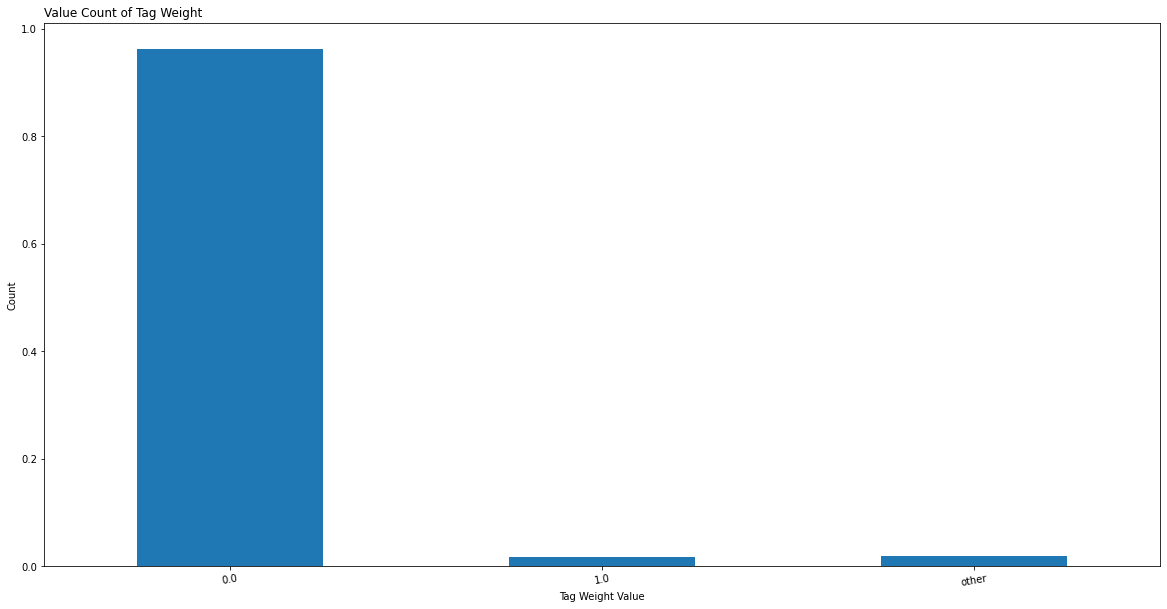

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
prob = train_data.tagWeight.value_counts(normalize=True)
threshold = 0.01
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(rotation=10)
plt.title("Value Count of Tag Weight", loc = 'left')
plt.xlabel("Tag Weight Value")
plt.ylabel("Count")
plt.show()

<AxesSubplot:>

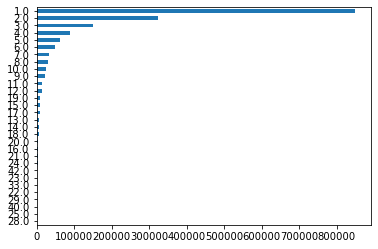

In [16]:
train_data.tagWeight.value_counts().sort_values().plot(kind = 'barh')


In [88]:
train_data['tagWeight'].value_counts()

0.0     45911079
1.0       850351
2.0       323015
3.0       150843
4.0        90211
5.0        63533
6.0        50430
7.0        33583
8.0        31650
10.0       24543
9.0        21849
11.0       15246
12.0       14564
19.0       10106
15.0        8682
17.0        8358
13.0        7128
14.0        6199
18.0        5962
20.0        4502
16.0        3965
21.0        3687
24.0        3199
42.0        1968
23.0        1476
33.0        1440
22.0        1329
29.0        1296
40.0         646
25.0         528
28.0         264
Name: tagWeight, dtype: int64

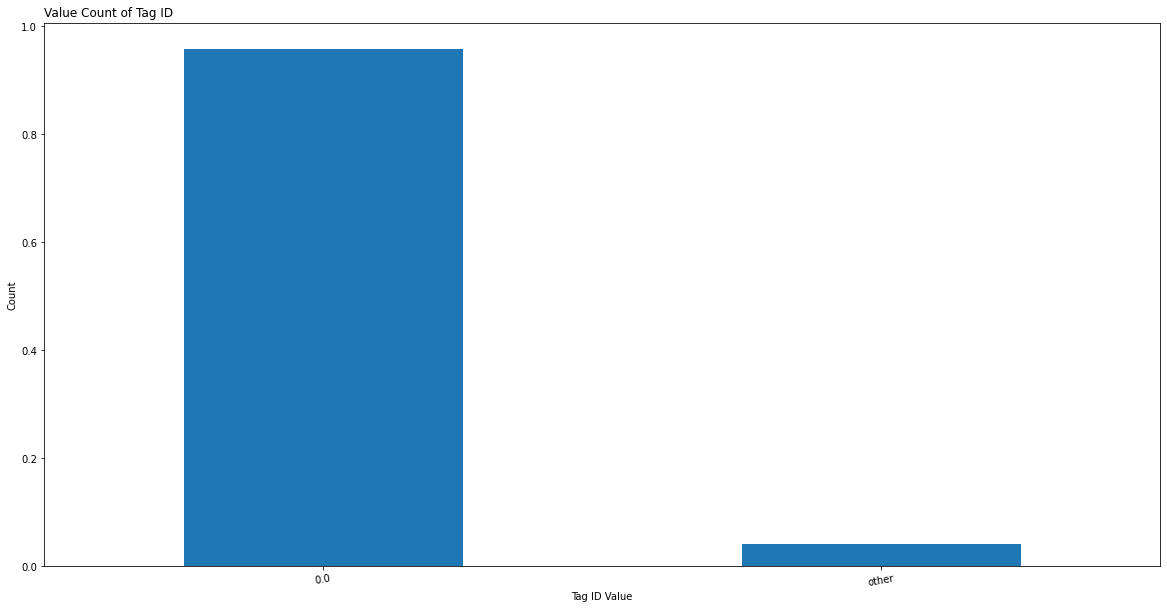

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
prob = train_data.tagID.value_counts(normalize=True)
threshold = 0.001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(rotation=10)
plt.title("Value Count of Tag ID", loc = 'left')
plt.xlabel("Tag ID Value")
plt.ylabel("Count")
plt.show()

In [87]:
train_data['tagID'].value_counts()

0.0        45678973
605.0         24557
1925.0        18801
74.0          17252
366.0         13526
             ...   
522.0             1
7528.0            1
8296.0            1
5058.0            1
16282.0           1
Name: tagID, Length: 7003, dtype: int64

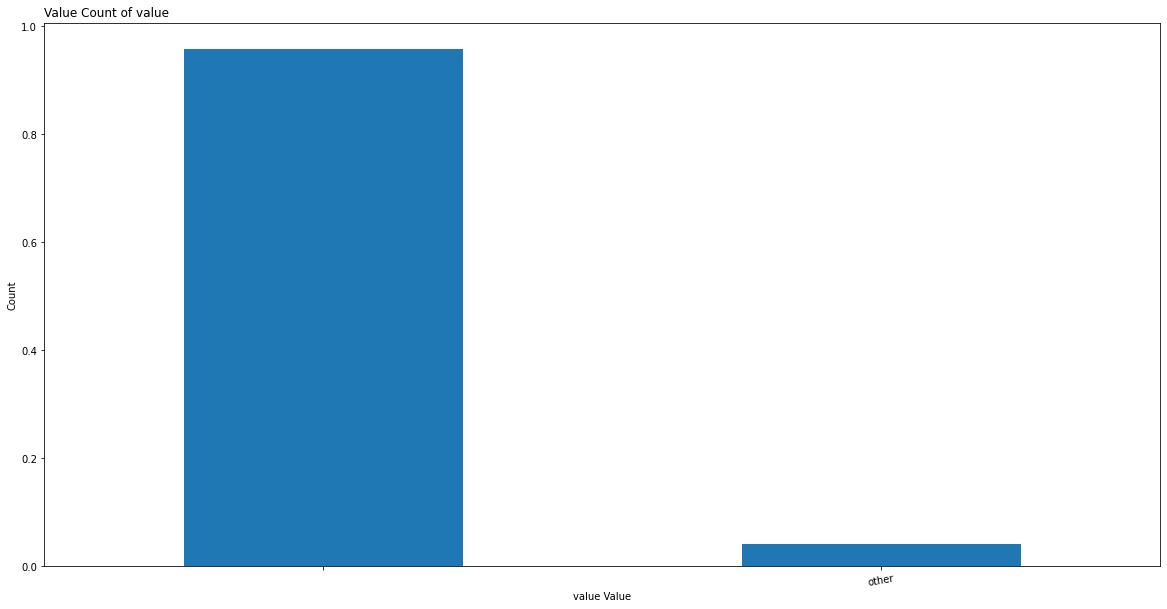

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
prob = train_data.value.value_counts(normalize=True)
threshold = 0.001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(rotation=10)
plt.title("Value Count of value", loc = 'left')
plt.xlabel("value Value")
plt.ylabel("Count")
plt.show()

In [13]:
train_data['value'].value_counts()

classic                 24557
erlends dvds            18801
action                  17252
scifi                   13526
seen more than once     11809
                        ...  
speech                      1
al gore                     1
gardening                   1
completely welldone         1
dont really remember        1
Name: value, Length: 7002, dtype: int64

In [71]:
train_data.actorID.value_counts()

tom_hanks            36677
samuel_l_jackson     35968
bruce_willis         35699
steve_buscemi        34080
john_ratzenberger    30279
                     ...  
anita_bardeleben         1
michael_ivins            1
_2066930                 1
_0485979                 1
kimberley_beck           1
Name: actorID, Length: 93982, dtype: int64

In [86]:
direct = train.merge(movie_actors, on='movieID', how='left')
groupbydirect=train.groupby('movieID')['rating'].mean().sort_values(ascending=False)
unique(groupbydirect)

array([[ 0.5       , 33.        ],
       [ 0.66666667,  1.        ],
       [ 0.7       ,  1.        ],
       ...,
       [ 4.75      ,  2.        ],
       [ 4.875     ,  1.        ],
       [ 5.        , 31.        ]])

In [83]:

def unique(a):
    unique, counts = np.unique(a, return_counts=True)
    return np.asarray((unique, counts)).T

In [14]:
train_data['rating'].value_counts()


4.0    11970603
3.0     8689840
3.5     8571539
4.5     4913953
5.0     3964673
2.5     3571278
2.0     3141529
1.0     1107163
1.5     1026193
0.5      694861
Name: rating, dtype: int64

In [14]:
#We will not join the tags and drop the unwanted columns as they 90% of the information is 0 or "".
# merge usertag and main train data (userid, movieid)
train_data = train.merge(user_taggedmovies, on=['userID','movieID'], how ='left')
train_data = train_data.merge(movie_tags, on=['movieID','tagID'], how = 'left')
train_data = train_data.merge(movie_genres, on='movieID', how = 'left')
train_data = train_data.merge(movie_directors, on='movieID', how = 'left')
train_data = train_data.merge(movie_actors, on='movieID', how='left')
#train_data = train_data.merge(tags, on='tagID', how='left')
train_data

,userID,movieID,rating,tagID,tagWeight,genre,directorID,directorName,actorID,actorName,ranking
0,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,annmargret,Ann-Margret,3.0
1,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,buck_henry,Buck Henry,8.0
2,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,buffy_sedlachek,Buffy Sedlachek,13.0
3,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,burgess_meredith,Burgess Meredith,4.0
4,75,3,1.0,NaN,NaN,Comedy,donald_petrie,Donald Petrie,christopher_mcdonald,Christopher McDonald,9.0
...,...,...,...,...,...,...,...,...,...,...,...
47651627,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,roger_lloyd_pack,Roger Lloyd Pack,17.0
47651628,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,rolf_saxon,Rolf Saxon,25.0
47651629,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,rupert_baderman,Rupert Baderman,8.0
47651630,71534,62049,4.5,NaN,NaN,Sci-Fi,michael_radford,Michael Radford,shirley_stelfox,Shirley Stelfox,19.0


In [ ]:
train_data_preprocessed=train_data.copy()
train_data_preprocessed

In [54]:
#Do one hot encoding for the column_Name 
def ONE_HOT_ENCODING(dataset, column_Name, prefix, remove_Original):
    new_columns=pd.get_dummies(dataset[column_Name],prefix=prefix, drop_first=True)
    if(remove_Original):
        dataset=dataset.drop(columns=[column_Name])
    dataset=pd.concat([dataset, new_columns], axis=1)
    #print(dataset)
    return dataset

def joinData(data):
    #joinedData = data.merge(user_taggedmovies, on=['userID','movieID'], how ='left')
    #tags = movie_tags.drop(columns=['tagWeight'])
    #tags = ONE_HOT_ENCODING(tags, "tagID", "tags", True)
    #tags = tags.groupby(['movieID']).sum()
    #joinedData = data.merge(tags, on=['movieID'], how = 'left')
    genre = ONE_HOT_ENCODING(movie_genres, "genre", "genre", True)
    genre = genre.groupby(['movieID']).sum()
    joinedData = data.merge(genre, on='movieID', how = 'left')
    actors = ONE_HOT_ENCODING(movie_actors, "ranking", "actor_ranking", True)
    actors = actors.groupby(['movieID']).sum()
    joinedData = data.merge(actors, on='movieID', how = 'left')
    joinedData = joinedData.merge(movie_directors, on='movieID', how = 'left')
    #joinedData = joinedData.merge(movie_actors, on='movieID', how='left')
    return joinedData

def preprocessData(data):
    #drop directorName actorName tagID tagWeight
    #data=data.drop(columns=['directorName', 'actorName','tagWeight','tagID'])
    data=data.drop(columns=['directorName'])
    #Categorical conversion of genre, directorID , actorID
    #data['actorID']=pd.Categorical(data.agctorID).codes
    data['directorID']=pd.Categorical(data.directorID).codes
    #data['genre']=pd.Categorical(data.genre).codes
    #data = ONE_HOT_ENCODING(data, "genre", "genre", True)
    data['userID'] = pd.to_numeric(data['userID'], errors='coerce')
    data['movieID'] =  pd.to_numeric(data['movieID'], errors='coerce')
    #data['genre'] =  pd.to_numeric(data['genre'], errors='coerce')
    data['directorID'] = pd.to_numeric(data['directorID'], errors='coerce')
    #data['actorID'] =  pd.to_numeric(data['actorID'], errors='coerce')
    #data['ranking'] =  pd.to_numeric(data['ranking'], errors='coerce')
    #Scaling of 'userID','movieID','rating','genre','directorID','actorID'
    #cols_to_norm=['userID','movieID','ranking','genre','directorID','actorID']
    cols_to_norm=['directorID']
    data[cols_to_norm] = preprocessing.MinMaxScaler().fit_transform(data[cols_to_norm])
    return data

In [55]:
# Joining the data and saving to csv

In [56]:
preprocessTrainData=preprocessData(joinData(train))
#preprocessTrainData=preprocessTrainData.groupby(['userID', 'movieID', 'rating','directorID']).sum()
preprocessTrainData

,userID,movieID,rating,actor_ranking_2,actor_ranking_3,actor_ranking_4,actor_ranking_5,actor_ranking_6,actor_ranking_7,actor_ranking_8,...,actor_ranking_212,actor_ranking_213,actor_ranking_214,actor_ranking_215,actor_ranking_216,actor_ranking_217,actor_ranking_218,actor_ranking_219,actor_ranking_220,directorID
0,75,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314329
1,75,32,4.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.883199
2,75,110,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684662
3,75,163,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834006
4,75,165,4.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.548436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641694,71534,42900,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845610
641695,71534,44555,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361756
641696,71534,46578,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032543
641697,71534,61075,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454339


In [27]:
csrTraining=csr_matrix(preprocessTrainData)
csrTraining

<641699x5319 sparse matrix of type '<class 'numpy.float64'>'
	with 152075275 stored elements in Compressed Sparse Row format>

In [ ]:
saveCSV(preprocessTrainData,"csrTraining.csv")

In [62]:
preprocessTestData=preprocessData(joinData(test))
preprocessTestData

,userID,movieID,actor_ranking_2,actor_ranking_3,actor_ranking_4,actor_ranking_5,actor_ranking_6,actor_ranking_7,actor_ranking_8,actor_ranking_9,...,actor_ranking_212,actor_ranking_213,actor_ranking_214,actor_ranking_215,actor_ranking_216,actor_ranking_217,actor_ranking_218,actor_ranking_219,actor_ranking_220,directorID
0,75,653,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.814535
1,75,1527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631471
2,75,3258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244086
3,75,7007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.954062
4,78,82,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.661296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71294,71534,2208,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092904
71295,71534,2997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.886527
71296,71534,4306,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104559
71297,71534,7132,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859787


In [ ]:
csrTest=csr_matrix(preprocessTestData)
csrTest

In [ ]:
saveCSV(preprocessTestData,"testdata.csv")

In [ ]:
preprocessTrainData[preprocessTrainData.duplicated()]

In [ ]:
preprocessTestData=preprocessTestData.drop_duplicates(keep='last')
preprocessTestData

In [ ]:
preprocessTrainData=preprocessTrainData.drop_duplicates(keep='last')
preprocessTrainData

In [ ]:
# Sorting values according to
# the 'num of rating column'
moviemat = preprocessTrainData.pivot_table(index ='user_id',
              columns ='title', values ='rating')
 
moviemat.head()
 
ratings.sort_values('num of ratings', ascending = False).head(10)

In [ ]:
trend=pd.DataFrame(preprocessTrainData.groupby('movieID')['rating'].mean())
trend['noofrating'] = pd.DataFrame(preprocessTrainData.groupby('movieID')['rating'].count()) 
trend.head()
ax=plt.bar(trend['rating'].round(),trend['noofrating'],color='b')
plt.show()

In [ ]:
preprocessTrainData.groupby('movieID')['rating'].mean().sort_values(ascending=False)

In [ ]:
preprocessTestDataPre = preprocessTestData.groupby(['userID', 'movieID']).sum()
preprocessTestDataPre

In [ ]:
preprocessTrainDataPre=preprocessTrainData.groupby(['userID', 'movieID']).sum()
preprocessTrainDataPre

In [ ]:
from sklearn.model_selection import KFold
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop=True)
    X, y = dataset.drop(columns=['rating']), dataset['rating']
    kFold = KFold(n_splits=n_folds)
    dataset_folds = list()
    for training_set_idx, test_set_idx in kFold.split(X, y):
        fold = {"training_set_X": X.iloc[training_set_idx], "test_set_X": X.iloc[test_set_idx],
                "training_set_Y": y.iloc[training_set_idx], "test_set_Y": y.iloc[test_set_idx],
                "test_idx": test_set_idx,"training_idx": training_set_idx}
        dataset_folds.append(fold)
    return dataset_folds
folds=cross_validation_split(preprocessTrainData,2)
folds[0]

In [ ]:
training_set_X=folds[0]['training_set_X']
test_set_X=folds[0]['test_set_X'] 
training_set_Y=folds[0]['training_set_Y']
test_set_Y=folds[0]['test_set_Y']

In [65]:
pdtest=preprocessTestData.fillna(0.0)
pdtest

,userID,movieID,actor_ranking_2,actor_ranking_3,actor_ranking_4,actor_ranking_5,actor_ranking_6,actor_ranking_7,actor_ranking_8,actor_ranking_9,...,actor_ranking_212,actor_ranking_213,actor_ranking_214,actor_ranking_215,actor_ranking_216,actor_ranking_217,actor_ranking_218,actor_ranking_219,actor_ranking_220,directorID
0,75,653,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.814535
1,75,1527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631471
2,75,3258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244086
3,75,7007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.954062
4,78,82,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.661296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71294,71534,2208,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092904
71295,71534,2997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.886527
71296,71534,4306,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104559
71297,71534,7132,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859787


In [58]:
preprocessTrainData=preprocessTrainData.dropna()
training_set_X, training_set_Y= preprocessTrainData.drop(columns=['rating']), preprocessTrainData['rating']
training_set_Y

0         1.0
1         4.5
2         4.0
3         4.0
4         4.5
         ... 
641694    4.0
641695    4.0
641696    4.0
641697    5.0
641698    4.5
Name: rating, Length: 640539, dtype: float64

In [59]:
training_set_X

,userID,movieID,actor_ranking_2,actor_ranking_3,actor_ranking_4,actor_ranking_5,actor_ranking_6,actor_ranking_7,actor_ranking_8,actor_ranking_9,...,actor_ranking_212,actor_ranking_213,actor_ranking_214,actor_ranking_215,actor_ranking_216,actor_ranking_217,actor_ranking_218,actor_ranking_219,actor_ranking_220,directorID
0,75,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314329
1,75,32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.883199
2,75,110,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684662
3,75,163,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834006
4,75,165,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.548436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641694,71534,42900,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845610
641695,71534,44555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361756
641696,71534,46578,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032543
641697,71534,61075,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454339


In [ ]:
preprocessTrainData.reset_index()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
training_set_X

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=151).fit(training_set_X, training_set_Y)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
regr = KNeighborsRegressor(n_neighbors=150)
regr.fit(training_set_X, training_set_Y)
output=regr.predict(pdtest)
#output=regr.predict(test_set_X)
output

In [70]:
saveOutput("adaBostclassiferwithactors.txt",output)

In [ ]:
from xgboost import XGBRegressor

preprocessTrainData=preprocessTrainData.dropna()
training_set_X, training_set_Y= preprocessTrainData.drop(columns=['rating']), preprocessTrainData['rating']

xgb_model = XGBRegressor(n_estimators=300, learning_rate=1.0, random_state=0)
xgb_model.fit(training_set_X, training_set_Y)

y_pred = xgb_model.predict(preprocessTestData)
y_pred

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(training_set_X, training_set_Y)
output=regr.predict(pdtest)
#output=regr.predict(test_set_X)
output

array([3.21716755, 3.18428371, 3.31273001, ..., 3.25280024, 3.26776337,
       3.26776337])

In [67]:
saveOutput("adaBostwithactors.txt",output)

In [32]:
np_round_to_tenths = np.around(output)
outputrouned=np.array(output) / 2
outputrouned

array([3.14820603, 3.14820603, 3.04753445, ..., 3.15095695, 3.04753445,
       3.04753445])

In [34]:
rounder = lambda x: round(x/0.5) * 0.5
vfunc = np.vectorize(rounder)
output5round = vfunc(outputrouned)

In [35]:
output5round

array([3., 3., 3., ..., 3., 3., 3.])

In [37]:
kdtttt = np.array([3.12, 3.45, 3.69, 3.76])

In [38]:
vfunc(kdtttt)

array([3. , 3.5, 3.5, 4. ])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_set_Y, output,squared=False)

In [39]:
saveOutput("adaBostwithX5roundedRating.txt",output5round)

In [ ]:
y_pred = knn.predict(preprocessTestDataPre)
y_pred

In [11]:
from sklearn.linear_model import LinearRegression

In [ ]:
preprocessTrainData=preprocessTrainData.dropna()
csr_matrix(preprocessTrainData.values)
training_set_X, training_set_Y= csr_matrix(preprocessTrainData.drop(columns=['rating'])), preprocessTrainData['rating']
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = LinearRegression()
regr.fit(training_set_X, training_set_Y)
y_pred = regr.predict(preprocessTestData)
y_pred

In [ ]:
saveOutput("RandomForestRegressor.txt",y_pred)

In [ ]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
accuracy_metric(test_set_Y,output)